# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import time

In [2]:
output_folder = "results"
PATH_TO_DATA = "data"
training_logs = 'training_logs'

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec:
    def __init__(self, fname: str, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {w: i for i, w in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))

    def load_wordvec(self, fname: str, nmax: int):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w: str, K=5) -> list:
        """Computes the K most similar words of the given word, using class function 'score'."""
        scores = np.array([self.score(w, w_vocab) if w_vocab != w else -1 for w_vocab in self.word2vec.keys()])
        idx_most_similar = np.argsort(-1 * scores)[:K]
        words_most_similar = [self.id2word[i] for i in idx_most_similar]
        return words_most_similar

    def score(self, w1: str, w2: str) -> float:
        """Computes the cosine similarity of the 2 given words"""
        w1_embedded = self.word2vec[w1]
        w2_embedded = self.word2vec[w2]
        return np.dot(w1_embedded, w2_embedded) / (np.linalg.norm(w1_embedded) * np.linalg.norm(w2_embedded))


In [4]:
begin = time.time()
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
print("Load duration : " + str(time.time() - begin) + "seconds\n")

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))

print("---------")

begin = time.time()
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, w2v.most_similar(w1))
print("Most similar duration : " + str(time.time() - begin) + "seconds")

Loaded 100000 pretrained word vectors
Load duration : 10.818530797958374seconds

cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
---------
cat ['cats', 'kitty', 'kitten', 'feline', 'kitties']
dog ['dogs', 'puppy', 'Dog', 'doggie', 'canine']
dogs ['dog', 'pooches', 'Dogs', 'doggies', 'canines']
paris ['france', 'Paris', 'london', 'berlin', 'tokyo']
germany ['austria', 'europe', 'german', 'berlin', 'poland']
Most similar duration : 4.973707675933838seconds


In [4]:
class BoV:
    def __init__(self, w2v):
        self.w2v: Word2vec = w2v
    
    def sentence_to_list(self, sentence: str) -> list:
        """Turn string into list by removing spaces and splitting compound words."""
        return sentence.replace('-', ' ').split()

    def encode(self, sentences: list, idf=False) -> np.array:
        """Takes a list of sentences, outputs a numpy array of sentence embeddings by computing
        the (idf-weighted) mean of words vector."""
        sentences_embedded = []
        for sent in sentences:
            sent = self.sentence_to_list(sent)
            words_weights = []
            words_embedded = []
            for word in sent:
                # Get embedding vector of each word of the sentence
                try:
                    words_embedded.append(self.w2v.word2vec[word])
                    words_weights.append(1 if idf is False else idf[word])  # Get weight of current word (idf or 1)
                except KeyError:
                    # If word is unknown, ignore it.
                    if len(words_embedded) == len(words_weights) + 1:  # 2 different datasets are used
                        words_weights.append(0)
                    continue
            # Average
            if len(words_embedded) > 0:
                sentences_embedded.append(np.average(words_embedded, weights=words_weights, axis=0))
        return np.array(sentences_embedded)

    def most_similar(self, s: str, sentences: list, idf=False, K=5) -> list:
        """Gets most similar sentences and **prints** them."""
        scores = np.array([self.score(s, sent, idf) if sent != s else -1 for sent in sentences])
        idx_most_similar = np.argsort(-1 * scores)[:K]
        sentences_most_similar = [sentences[i] for i in idx_most_similar]
        print(str(K) + ' most similar sentences with : "' + s + '"\n')
        print(sentences_most_similar)
        return sentences_most_similar

    def score(self, s1: str, s2: str, idf=False):
        """Computes the cosine similarity of the 2 given sentences"""
        s1_encoded = self.encode([s1], idf).reshape(-1,)
        s2_encoded = self.encode([s2], idf).reshape(-1,)
        if np.shape(s1_encoded) == (0,) or np.shape(s2_encoded) == (0,):  # Unknown sentence: irrelevant.
            return -1
        return np.dot(s1_encoded, s2_encoded) / (np.linalg.norm(s1_encoded) * np.linalg.norm(s2_encoded))

    def build_idf(self, sentences: list) -> dict:
        """Builds the idf dictionary: associates each word to its idf value."""
        idf = {}
        # Computes the number of documents where each term appears
        for sent in sentences:
            sent = self.sentence_to_list(sent)
            for i, word in enumerate(sent):
                if word not in sent[:i]:  # Consider a term only once per document
                    idf[word] = idf.get(word, 0) + 1
        # Computes the idf
        for word in idf.keys():
            idf[word] = np.log10(len(sentences) / idf[word])
        return idf


In [6]:
def read_sentences(filename: str) -> list:
    """Extracts the sentences from the given file and returns them in a list."""
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.readlines()
        sentences = [line.rstrip() for line in content]  # Remove final newline character
        return sentences


w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = read_sentences(os.path.join(PATH_TO_DATA, 'sentences.txt'))

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar(sentences[10], sentences)  # BoV-mean
print('-------------')
print('"' + sentences[7] + '" --- "' + sentences[15] + '" -->', s2v.score(sentences[7], sentences[13]))
print('\n-------------\n')

s2v.most_similar(sentences[10], sentences, idf)  # BoV-idf
print('-------------')
print(s2v.score(sentences[7], sentences[13], idf))


Loaded 5000 pretrained word vectors
5 most similar sentences with : "1 smiling african american boy ."

['blond boy waterskiing .', 'a boy surfs .', 'a boy jumps .', 'a boy blowing bubbles .', 'a boy wears sunglasses .']
-------------
"1 man singing and 1 man playing a saxophone in a concert ." --- "11 cheerleaders in yellow and white on a football field , 8 of which are doing a lift ." --> 0.6089445116147133

-------------

5 most similar sentences with : "1 smiling african american boy ."

['a man rides a 4 wheeler in the desert .', 'a man in black is juggling 3 flamed bottles .', '5 women and 1 man are smiling for the camera .', '3 males and 1 woman enjoying a sporting event', 'a young boy in the water in 2 floating tubes .']
-------------
0.5536982553441099


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
def load_voc_data(nb_vectors=50000) -> tuple:
    """Extracts the first given vectors from the French and English vocabulary data."""
    def extract_sentences(filename: str) -> tuple:
        """Extracts the vectors and labels from the vocabulary data."""
        with open(filename, 'r', encoding='utf-8') as file:
            vectors = []
            labels = []
            for i, line in enumerate(file):
                if i > 0:
                    splitted_line = line.split()
                    # A label can appear several times: we just take it once
                    if splitted_line[0] not in labels:
                        try:
                            values = np.array(splitted_line[1:]).astype(float)
                            # Few problems with dimensions, we ignore them
                            if values.shape != (300,):
                                continue
                            else:
                                vectors.append(values)
                                labels.append(splitted_line[0])
                        except:  # Ignore if some weird label appears like 'france »'
                            continue
                    if len(labels) == nb_vectors:
                        return np.array(vectors), labels
    
    en_vectors, en_labels = extract_sentences(os.path.join(PATH_TO_DATA, 'wiki.en.vec'))
    fr_vectors, fr_labels = extract_sentences(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'))
    return en_vectors, en_labels, fr_vectors, fr_labels

en_vectors, en_labels, fr_vectors, fr_labels = load_voc_data(50000)
print('Loaded data :')
print(en_vectors.shape, fr_vectors.shape)
print(len(en_labels), len(fr_labels))

Loaded data :
(50000, 300) (50000, 300)
50000 50000


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
common_words = []
X = []
Y = []
for i, french_word in enumerate(fr_labels):
    for j, english_word in enumerate(en_labels):
        if french_word == english_word:
            common_words.append(french_word)
            X.append(fr_vectors[i])
            Y.append(en_vectors[j])
            break

print('Found ' + str(len(common_words)) + ' common words.')
X = np.array(X)
Y = np.array(Y)

Found 18982 common words.


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
from scipy.linalg import svd

U, _, Vh = svd(Y.T.dot(X))
W = U.dot(Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
import random


def most_similar(word, direction='fr_en', K=5) -> list:
    """Computes the K most similar words of the given word, using function 'score'."""
    # Check direction of translation
    if direction == 'fr_en':
        X_mat = fr_vectors
        Y_mat = en_vectors
        W_mat = W
        source_labels = fr_labels
        target_labels = en_labels
    elif direction == 'en_fr':
        X_mat = en_vectors
        Y_mat = fr_vectors
        W_mat = W.T
        source_labels = en_labels
        target_labels = fr_labels
    
    # Get the source word
    if type(word) == str:
        idx_word = source_labels.find(word)
    else:
        idx_word = word
    
    # Compute scores and nearest neighbors
    scores = np.array([cosine_similarity(W_mat.dot(X_mat[idx_word]), y) for y in Y_mat])
    idx_most_similar = np.argsort(-1 * scores)[:K]
    words_most_similar = [target_labels[i] for i in idx_most_similar]
    print('Most similar translation for "' + source_labels[idx_word] + '" (' + direction + ') :')
    print(words_most_similar)
    return words_most_similar

def cosine_similarity(v1: np.array, v2: np.array) -> float:
    """Computes the cosine similarity of the 2 given vectors"""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Try a few words:
for i in range(10):
    idx_word = random.randint(0, len(fr_labels))
    direction = random.choice(['fr_en', 'en_fr'])
    most_similar(idx_word, direction)
    print('------')

Most similar translation for "serbo" (en_fr) :
['serbo', 'bosniaque', 'monténégrin', 'croate', 'serbe']
------
Most similar translation for "mollusque" (fr_en) :
['mollusc', 'bivalve', 'bivalves', 'crustacean', 'snail']
------
Most similar translation for "tripoli" (en_fr) :
['tripoli', 'beyrouth', 'tripolitaine', 'benghazi', 'tunis']
------
Most similar translation for "dénouement" (fr_en) :
['cliffhanger', 'melodramatic', 'unfolds', 'intrigue', 'subplot']
------
Most similar translation for "bryn" (fr_en) :
['bryn', 'mawr', 'haverford', 'glyn', 'aberystwyth']
------
Most similar translation for "foch" (en_fr) :
['foch', 'joffre', 'weygand', 'gaulle', 'stalingrad']
------
Most similar translation for "electricity" (en_fr) :
['électricité', 'hydroélectricité', 'énergie', 'photovoltaïque', 'kwh']
------
Most similar translation for "établissement" (fr_en) :
['conseil', 'establishment', 'institution', 'collège', 'institutions']
------
Most similar translation for "jailed" (en_fr) :
['inc

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [26]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_sst_data(folder: str) -> tuple:
    """Extracts the SST data from the given folder (sentences and labels from each set)."""
    def extract_sentences(filename: str, is_testing_set=False) -> tuple:
        """Extracts the sentences and labels from the given file from the SST dataset."""
        with open(filename, 'r', encoding='utf-8') as file:
            sentences = []
            labels = []
            for line in file.readlines():
                if is_testing_set:  # No label in testing set
                    sentences.append(line)
                else:
                    labels.append(int(line[0]))
                    sentences.append(line[2:])
        return sentences, labels

    tr_sentences, tr_labels = extract_sentences(os.path.join(folder, 'stsa.fine.train'))
    val_sentences, val_labels = extract_sentences(os.path.join(folder, 'stsa.fine.dev'))
    te_sentences, _ = extract_sentences(os.path.join(folder, 'stsa.fine.test.X'), is_testing_set=True)

    return tr_sentences, tr_labels, val_sentences, val_labels, te_sentences


tr_sentences, tr_labels, val_sentences, val_labels, te_sentences = load_sst_data(os.path.join(PATH_TO_DATA, 'SST'))

In [27]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=50000)
s2v = BoV(w2v)

# Decide whether to use IDF or not
idf = False
# idf = s2v.build_idf(tr_sentences)  # Build IDF only on the testing set

X_tr = s2v.encode(tr_sentences, idf)
X_val = s2v.encode(val_sentences, idf)
X_te = s2v.encode(te_sentences, idf)

Loaded 50000 pretrained word vectors


In [28]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import accuracy_score

# Create PredefinedSplit object for fixed cross validation
X_all = np.vstack((X_tr, X_val))
y_all = tr_labels + val_labels
seperation_indices = [-1 for i in range(len(tr_labels))]  # Training part
seperation_indices += [1 for i in range(len(val_labels))]  # Validation part
ps = PredefinedSplit(seperation_indices)

"""
Fine-tune 'C' value
Uncomment the following part to test it
"""
# parameters = {'C': np.logspace(-4, 4, 20)}
# clf = GridSearchCV(LogisticRegression(), param_grid=parameters, cv=ps)
# clf.fit(X_all, y_all)
# print(clf.best_params_)

# Test with best C = 1.623776739188721
clf = LogisticRegression(C=1.623776739188721)
clf.fit(X_tr, tr_labels)

print('Accuracy training set = ', accuracy_score(tr_labels, clf.predict(X_tr)))
print('Accuracy validation set = ', accuracy_score(val_labels, clf.predict(X_val)))


Accuracy training set =  0.4853698501872659
Accuracy validation set =  0.4332425068119891


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_predicted = clf.predict(X_te)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
with open(os.path.join(output_folder, 'logreg_bov_y_test_sst.txt'), 'w') as file:
    for i in y_predicted:
        file.write(str(i) + '\n')

In [31]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# PCA
pca = PCA(200)
X_tr_reduced = pca.fit_transform(X_tr)
X_val_reduced = pca.transform(X_val)
X_te_reduced = pca.transform(X_te)

"""
Fine-tune 'C' value.
Uncomment the following part to test it
"""
# Create PredefinedSplit object for fixed cross validation
# X_all_reduced = np.vstack((X_tr_reduced, X_val_reduced))
# y_all = tr_labels + val_labels
# seperation_indices = [-1 for i in range(len(tr_labels))]  # Training part
# seperation_indices += [1 for i in range(len(val_labels))]  # Validation part
# ps = PredefinedSplit(seperation_indices)
# parameters = {'C': np.logspace(-4, 4, 20)}
# better_clf = GridSearchCV(SVC(), param_grid=parameters, cv=ps, verbose=True)
# better_clf.fit(X_all_reduced, y_all)
# print(better_clf.best_params_)

# Test with best C = 206.913808111479
better_clf = SVC(C=206.913808111479)
better_clf.fit(X_tr_reduced, tr_labels)

print('Accuracy training set = ', accuracy_score(tr_labels, better_clf.predict(X_tr_reduced)))
print('Accuracy validation set = ', accuracy_score(val_labels, better_clf.predict(X_val_reduced)))

# Save
y_predicted = better_clf.predict(X_te_reduced)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
with open(os.path.join(output_folder, 'svm_bov_y_test_sst.txt'), 'w') as file:
    for i in y_predicted:
        file.write(str(i) + '\n')

Accuracy training set =  0.4785814606741573
Accuracy validation set =  0.4232515894641235


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import keras

Using TensorFlow backend.


In [4]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_sst_data(folder: str) -> tuple:
    """Extracts the SST data from the given folder (sentences and labels from each set)."""
    def extract_sentences(filename: str, is_testing_set=False) -> tuple:
        """Extracts the sentences and labels from the given file from the SST dataset."""
        with open(filename, 'r', encoding='utf-8') as file:
            sentences = []
            labels = []
            for line in file.readlines():
                if is_testing_set:  # No label in testing set
                    sentences.append(line)
                else:
                    labels.append(int(line[0]))
                    sentences.append(line[2:])
        return sentences, labels

    tr_sentences, tr_labels = extract_sentences(os.path.join(folder, 'stsa.fine.train'))
    val_sentences, val_labels = extract_sentences(os.path.join(folder, 'stsa.fine.dev'))
    te_sentences, _ = extract_sentences(os.path.join(folder, 'stsa.fine.test.X'), is_testing_set=True)

    return tr_sentences, tr_labels, val_sentences, val_labels, te_sentences


# It's the same function as defined in part 3
tr_sentences, y_tr, val_sentences, y_val, te_sentences = load_sst_data(os.path.join(PATH_TO_DATA, 'SST'))

In [5]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
import re
from keras.preprocessing.text import one_hot


def get_some_stats(*sentences: list):
    """Computes and displays the min, max, mean, median sentences length and the number of unique words."""
    unique_words = set()
    sentences_len = []
    for sentences_list in sentences:
        for sent in sentences_list:
            sentences_len.append(len(re.sub(r'[^\w\s]', '', sent).split()))
            for word in re.sub(r'[^\w\s]', '', sent).split():
                if word not in unique_words:
                    unique_words.add(word)                
    print('Min sentences length = ', np.min(sentences_len))
    print('Mean sentences length = ', np.mean(sentences_len))
    print('Median sentences length = ', np.median(sentences_len))
    print('Max sentences length = ', np.max(sentences_len))
    print('Number of unique words = ', len(unique_words))


get_some_stats(tr_sentences, val_sentences, te_sentences)

nb_unique_words = 15000
X_tr = [one_hot(line, nb_unique_words, filters='#*+-/<=>@[\]^_{|}~', lower=False) for line in tr_sentences]
X_val = [one_hot(line, nb_unique_words, filters='#*+-/<=>@[\]^_{|}~', lower=False) for line in val_sentences]
X_te = [one_hot(line, nb_unique_words, filters='#*+-/<=>@[\]^_{|}~', lower=False) for line in te_sentences]

Min sentences length =  1
Mean sentences length =  17.049936735554617
Median sentences length =  16.0
Max sentences length =  52
Number of unique words =  19375


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [6]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

# The maximum length of all sequences is = 52 (from the testing set).
maxlen = 40
X_tr = pad_sequences(X_tr, maxlen=maxlen, padding='post')
X_val = pad_sequences(X_val, maxlen=maxlen, padding='post')
X_te = pad_sequences(X_te, maxlen=maxlen, padding='post')

print(np.shape(X_tr))
print(np.shape(X_val))
print(np.shape(X_te))

(8544, 40)
(1101, 40)
(2210, 40)


## 4.2 - Design and train your model

In [7]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise

embed_dim = 128  # word embedding dimension
nhid = 64  # number of hidden units in the LSTM
vocab_size = nb_unique_words  # size of the vocabulary
n_classes = 5

model = Sequential()
model.add(GaussianNoise(0.01, input_shape=(maxlen,)))  # To diminish the overfitting
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.5, dropout_U=0.5))
model.add(Dense(n_classes, activation='softmax'))

d:\applications\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.5, recurrent_dropout=0.5)`


In [8]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras.optimizers import RMSprop, Adam


loss_classif = 'sparse_categorical_crossentropy'  # find the right loss for multi-class classification
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)  # find the right optimizer
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
metrics_classif = ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 128)           1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,969,733
Trainable params: 1,969,733
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/12
8544/8544 [==============================] - 8s 978us/step - loss: 1.5757 - acc: 0.2617 - val_loss: 1.5779 - val_acc: 0.2625
Epoch 2/12
8544/8544 [==============================] - 6s 747us/step - loss: 1.5697 - acc: 0.2693 - val_loss: 1.5784 - val_acc: 0.2534
Epoch 3/12
8544/8544 [==============================] - 6s 727us/step - loss: 1.5660 - acc: 0.2753 - val_loss: 1.5739 - val_acc: 0.2561
Epoch 4/12
8544/8544 [==============================] - 7s 786us/step - loss: 1.5531 - acc: 0.2808 - val_loss: 1.5764 - val_acc: 0.2816
Epoch 5/12
8544/8544 [==============================] - 6s 738us/step - loss: 1.4833 - acc: 0.3548 - val_loss: 1.5024 - val_acc: 0.3379
Epoch 6/12
8544/8544 [==============================] - 7s 837us/step - loss: 1.3776 - acc: 0.4044 - val_loss: 1.5120 - val_acc: 0.3424
Epoch 7/12
8544/8544 [==============================] - 7s 767us/step - loss: 1.3022 - acc: 0.4316 - val_loss: 1.5275 - val_acc: 0.3560


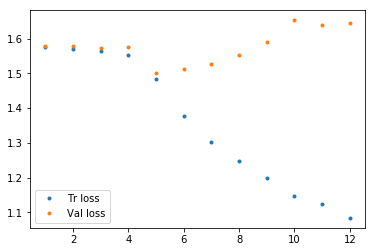

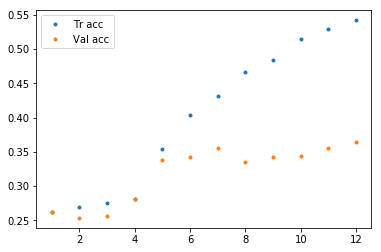

In [10]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

# Tensorboard to follow training
if not os.path.exists(training_logs):
    os.makedirs(training_logs)
tensorboard = TensorBoard(log_dir=training_logs)

# Fit
bs = 128
n_epochs = 12
history = model.fit(X_tr, y_tr, batch_size=bs, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[tensorboard])

# Plot training
abscissa = 1 + np.arange(n_epochs)
# Loss
plt.figure()
plt.plot(abscissa, history.history['loss'], '.', label='Tr loss')
plt.plot(abscissa, history.history['val_loss'], '.', label='Val loss')
plt.legend()

# Accuracy
plt.figure()
plt.plot(abscissa, history.history['acc'], '.', label='Tr acc')
plt.plot(abscissa, history.history['val_acc'], '.', label='Val acc')
plt.legend()

plt.show()

In [11]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_predicted = model.predict(X_te).argmax(axis=-1)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
with open(os.path.join(output_folder, 'logreg_lstm_y_test_sst.txt'), 'w') as file:
    for i in y_predicted:
        file.write(str(i) + '\n')

## 4.3 -- innovate !

**<font color='red'>/!\ Read this cell</font>**

I had the following error when trying to run the code on Jupyter Notebook : "The kernel appears to have died. It will restart automatically.". According to [this](https://github.com/tensorflow/tensorflow/issues/9829#issuecomment-300783730), it must be run on a `.py` file.

So please, you'll find the code for this question in the file `question43.py`.

I got inspired by [this blog](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html): you need to download the [GloVe embeddings vectors](http://nlp.stanford.edu/data/glove.6B.zip).

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE